# Goemans-Williamson algorithm for Maxcut problem
This notebook implements the Goemans-Williamson algorithm, runs time-budgeted experiments on multiple random graphs per size, and saves results for later statistical analysis.

In [2]:
import networkx as nx
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
import os
from datetime import datetime

## Graph generating function

In [3]:
def generate_random_graph(n_nodes=8, p=0.5, seed=None):
    G = nx.erdos_renyi_graph(n_nodes, p, seed=seed)
    
    for (u, v) in G.edges():
        G.edges[u, v]['weight'] = np.random.randint(1, 10)

    return G

## Algorithm

In [4]:
def goemans_williamson_maxcut(G, num_rounds=50, seed=None):
    np.random.seed(seed)
    n = G.number_of_nodes()
    W = nx.to_numpy_array(G, weight='weight')
    
    # SDP relaxation
    X = cp.Variable((n, n), symmetric=True)
    constraints = [X >> 0, cp.diag(X) == 1]
    objective = cp.Maximize(0.25 * cp.sum(cp.multiply(W, 1 - X)))
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS, verbose=False)
    X_opt = X.value

    if X_opt is None:
        print(f"Warning: SDP solver failed for a graph of size {n}. Returning a null cut.")
        return np.zeros(n, dtype=bool), 0

    # Rounding
    vals, vecs = np.linalg.eigh(X_opt)
    V = vecs @ np.diag(np.sqrt(np.maximum(vals, 0)))
    best_cut = None
    best_value = -np.inf

    L = nx.laplacian_matrix(G).toarray()

    for _ in range(num_rounds):
        r = np.random.randn(n)
        r /= np.linalg.norm(r)
        
        y = np.ones(n)
        y[V @ r < 0] = -1

        cut_value = 0.25 * y.T @ L @ y

        if cut_value > best_value:
            best_value = cut_value
            best_cut = (y == 1)

    return best_cut, best_value

## Test of functionality

Best cut value: 71.0


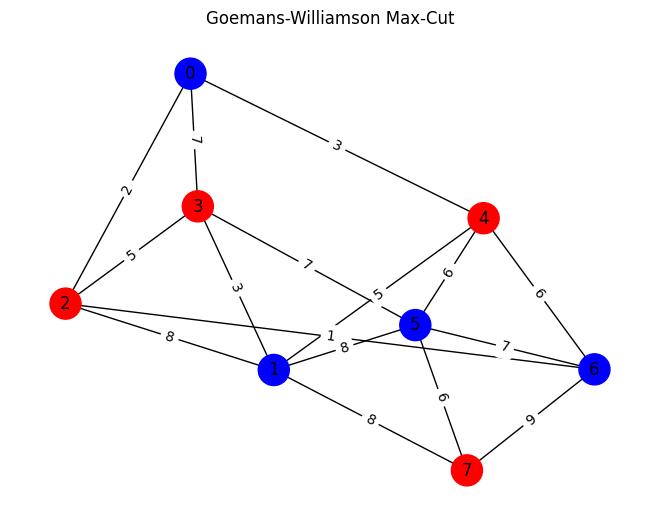

In [5]:
G = generate_random_graph(n_nodes=8, p=0.5, seed=42)
cut, value = goemans_williamson_maxcut(G, num_rounds=100, seed=42)
print(f"Best cut value: {value}")

pos = nx.spring_layout(G, seed=42)
colors = ['red' if cut[node] else 'blue' for node in G.nodes()]
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=500)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Goemans-Williamson Max-Cut")
plt.show()

## Experiment function

In [6]:
def run_gw_experiment_time_budget(sizes, edge_prob=0.5, time_per_size=420, num_rounds=50):
    all_cut_values = []
    for n_nodes in sizes:
        cut_values = []
        start_time = time.time()
        g_idx = 0
        while time.time() - start_time < time_per_size:
            G = generate_random_graph(n_nodes=n_nodes, p=edge_prob, seed=g_idx)
            cut, value = goemans_williamson_maxcut(G, num_rounds=num_rounds)
            cut_values.append(value)
            g_idx += 1
        all_cut_values.append(cut_values)
        print(f"Size: {n_nodes} | Graphs: {g_idx} | Mean Cut: {np.mean(cut_values):.2f} | Std: {np.std(cut_values):.2f}")
    return all_cut_values

## Experiment Setup
- Graph sizes: 25, 50, 75, 100, 125, 150, 175, 200 nodes
- Edge probability: 0.5
- Time per size: 400 seconds

Size: 25 | Graphs: 13530 | Mean Cut: 516.38 | Std: 32.56
Size: 50 | Graphs: 1598 | Mean Cut: 1933.99 | Std: 63.21
Size: 75 | Graphs: 568 | Mean Cut: 4198.06 | Std: 87.75
Size: 100 | Graphs: 219 | Mean Cut: 7283.51 | Std: 116.88
Size: 125 | Graphs: 103 | Mean Cut: 11235.60 | Std: 164.97
Size: 150 | Graphs: 63 | Mean Cut: 15984.76 | Std: 183.92
Size: 175 | Graphs: 40 | Mean Cut: 21634.50 | Std: 216.60
Size: 200 | Graphs: 30 | Mean Cut: 28005.77 | Std: 192.54
Results saved to data/gw-data/gw_20250616_093740.csv


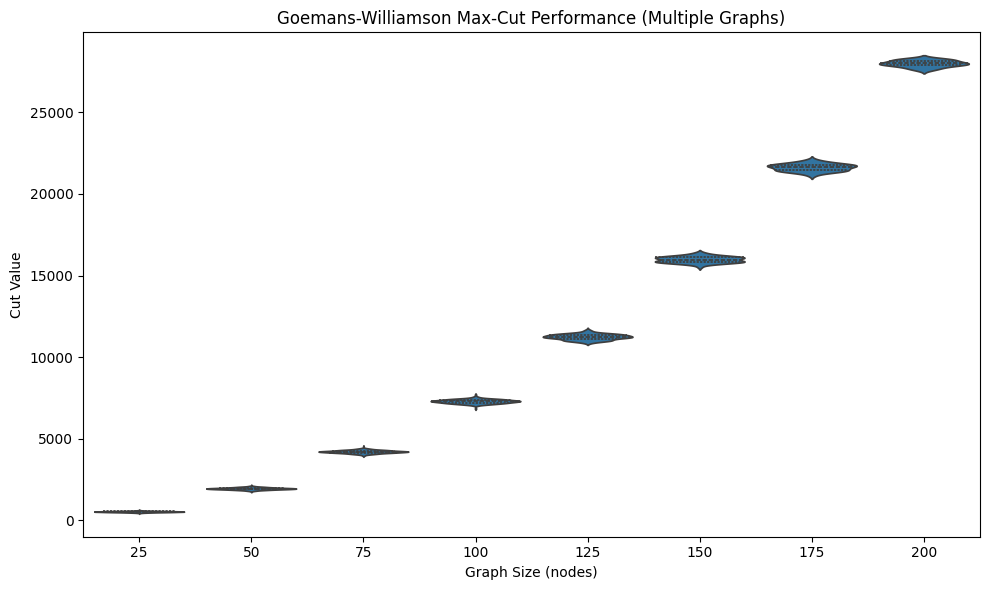

Plot saved to plots/gw-plots/gw_violin_20250616_093740.png


In [12]:
sizes = [25, 50, 75, 100, 125, 150, 175, 200]
edge_prob = 0.5
time_per_size = 450 # seconds
num_rounds = 50

cut_values = run_gw_experiment_time_budget(sizes, edge_prob, time_per_size, num_rounds)

df = pd.DataFrame({
    'Graph Size': sum([[size]*len(vals) for size, vals in zip(sizes, cut_values)], []),
    'Cut Value': sum(cut_values, [])
})

# Save CSV
os.makedirs("data/gw-data", exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path = f"data/gw-data/gw_{timestamp}.csv"
df.to_csv(csv_path, index=False)
print(f"Results saved to {csv_path}")

# Save plot
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
plot_path = f"plots/gw-plots/gw_violin_{timestamp}.png"

plt.figure(figsize=(10,6))
sns.violinplot(x='Graph Size', y='Cut Value', data=df, inner='quartile', density_norm='width')
plt.title('Goemans-Williamson Max-Cut Performance (Multiple Graphs)')
plt.xlabel('Graph Size (nodes)')
plt.ylabel('Cut Value') 
plt.tight_layout()
plt.savefig(plot_path)
plt.show()
print(f"Plot saved to {plot_path}")

## Experiment for sizes equivalent to exact algorithms

Size: 8 | Graphs: 88014 | Mean Cut: 57.62 | Std: 11.49
Size: 10 | Graphs: 77852 | Mean Cut: 89.05 | Std: 14.10
Size: 12 | Graphs: 65687 | Mean Cut: 126.71 | Std: 16.67
Size: 14 | Graphs: 53661 | Mean Cut: 170.37 | Std: 19.13
Size: 16 | Graphs: 44877 | Mean Cut: 219.95 | Std: 21.44
Size: 18 | Graphs: 37337 | Mean Cut: 275.82 | Std: 24.05
Results saved to data/gw-data/gw_20250616_124601.csv


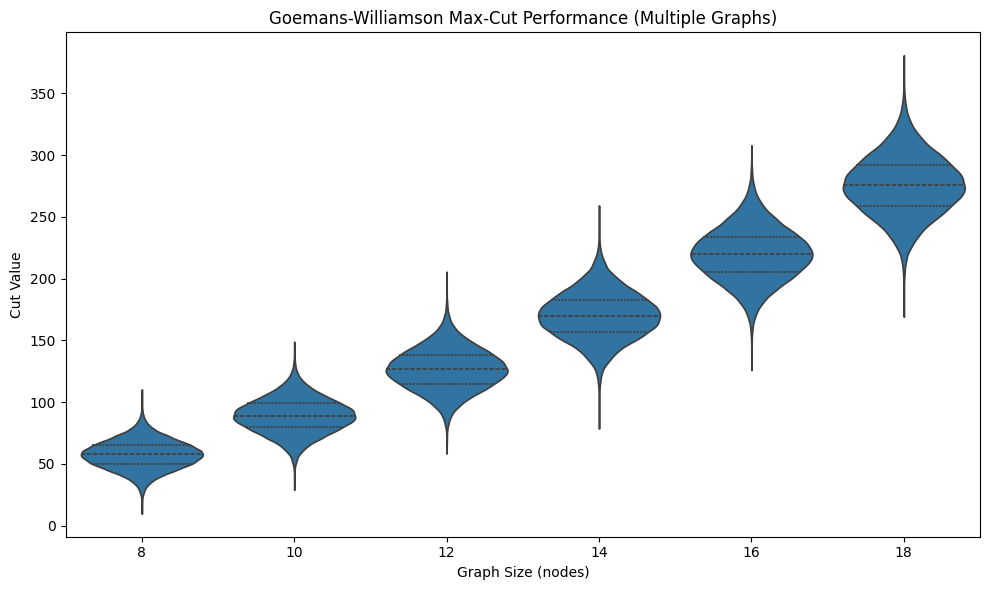

Plot saved to plots/gw-plots/gw_violin_20250616_124601.png


In [ ]:
sizes = [8, 10, 12, 14, 16, 18]
edge_prob = 0.5
time_per_size = 600  # seconds
# 6 sizes with 600 seconds each = 1 hour total
num_rounds = 50

cut_values = run_gw_experiment_time_budget(sizes, edge_prob, time_per_size, num_rounds)

df = pd.DataFrame({
    'Graph Size': sum([[size]*len(vals) for size, vals in zip(sizes, cut_values)], []),
    'Cut Value': sum(cut_values, [])
})

# Save CSV
os.makedirs("data/gw-data", exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path = f"data/gw-data/gw_small_{timestamp}.csv"
df.to_csv(csv_path, index=False)
print(f"Results saved to {csv_path}")

# Save plot
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
plot_path = f"plots/gw-plots/gw_small_violin_{timestamp}.png"

plt.figure(figsize=(10,6))
sns.violinplot(x='Graph Size', y='Cut Value', data=df, inner='quartile', density_norm='width')
plt.title('Goemans-Williamson Max-Cut Performance (Multiple Graphs)')
plt.xlabel('Graph Size (nodes)')
plt.ylabel('Cut Value') 
plt.tight_layout()
plt.savefig(plot_path)
plt.show()
print(f"Plot saved to {plot_path}")